# Supervised vs. Unsuppervised 

```{admonition} Objectives
In this chapter
  * Define features, labels
  * Distinguish between supervised and unsupervised learning
  * Understand what a loss function is and how it can be minimized with gradient descent
  * Understand what model is and its connection to features and labels
  * Be able to cluster data and describe what it tells us about data
```

## Supervised Learning

**Supervised learning** means predicting $y$ from $\vec{x}$ with a model trained on data. It is *supervised* because we tell the algorithm what the labels are in our dataset. Another method we'll explore is **unsupervised learning** where we do not tell the algorithm the labels. We'll see this supervised/unsupervised distinction can be more subtle later on, but this is a great definition for now. 

To see an example, we will use a dataset called AqSolDB{cite}`Sorkun2019` that is about 10,000 unique compounds with measured solubility in water (label). The dataset also includes molecular properties (features) that we can use for machine learning. The solubility measurement is solubility of the compound in water in units of log molarity.

To install packages, execute this code in a new cell. 
```
!pip install "jax[cpu]===0.3.14" -f https://whls.blob.core.windows.net/unstable/index.html --use-deprecated legacy-resolver
```

In [4]:
## set env
import sys, re, os
from pathlib  import Path
dir_nb = Path(globals()['_dh'][0])  

import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np
import jax.numpy as jnp
import jax
from jax.example_libraries import optimizers
import sklearn.manifold, sklearn.cluster
import rdkit, rdkit.Chem, rdkit.Chem.Draw

import warnings
warnings.filterwarnings("ignore")
plt.style.use(str(dir_nb.parents[1]/"code/light.mplstyle"))


### Load Data

Download the data and load it into a [Pandas](https://pandas.pydata.org/) DataFrame.

In [2]:
soldata = pd.read_csv( "https://github.com/whitead/dmol-book/raw/main/data/curated-solubility-dataset.csv")
soldata.head()

,ID,Name,InChI,InChIKey,SMILES,Solubility,SD,Ocurrences,Group,MolWt,...,NumRotatableBonds,NumValenceElectrons,NumAromaticRings,NumSaturatedRings,NumAliphaticRings,RingCount,TPSA,LabuteASA,BalabanJ,BertzCT
0,A-3,"N,N,N-trimethyloctadecan-1-aminium bromide",InChI=1S/C21H46N.BrH/c1-5-6-7-8-9-10-11-12-13-...,SZEMGTQCPRNXEG-UHFFFAOYSA-M,[Br-].CCCCCCCCCCCCCCCCCC[N+](C)(C)C,-3.616127,0.0,1,G1,392.510,...,17.0,142.0,0.0,0.0,0.0,0.0,0.00,158.520601,0.000000e+00,210.377334
1,A-4,Benzo[cd]indol-2(1H)-one,InChI=1S/C11H7NO/c13-11-8-5-1-3-7-4-2-6-9(12-1...,GPYLCFQEKPUWLD-UHFFFAOYSA-N,O=C1Nc2cccc3cccc1c23,-3.254767,0.0,1,G1,169.183,...,0.0,62.0,2.0,0.0,1.0,3.0,29.10,75.183563,2.582996e+00,511.229248
2,A-5,4-chlorobenzaldehyde,InChI=1S/C7H5ClO/c8-7-3-1-6(5-9)2-4-7/h1-5H,AVPYQKSLYISFPO-UHFFFAOYSA-N,Clc1ccc(C=O)cc1,-2.177078,0.0,1,G1,140.569,...,1.0,46.0,1.0,0.0,0.0,1.0,17.07,58.261134,3.009782e+00,202.661065
3,A-8,"zinc bis[2-hydroxy-3,5-bis(1-phenylethyl)benzo...",InChI=1S/2C23H22O3.Zn/c2*1-15(17-9-5-3-6-10-17...,XTUPUYCJWKHGSW-UHFFFAOYSA-L,[Zn++].CC(c1ccccc1)c2cc(C(C)c3ccccc3)c(O)c(c2)...,-3.924409,0.0,1,G1,756.226,...,10.0,264.0,6.0,0.0,0.0,6.0,120.72,323.755434,2.322963e-07,1964.648666
4,A-9,4-({4-[bis(oxiran-2-ylmethyl)amino]phenyl}meth...,InChI=1S/C25H30N2O4/c1-5-20(26(10-22-14-28-22)...,FAUAZXVRLVIARB-UHFFFAOYSA-N,C1OC1CN(CC2CO2)c3ccc(Cc4ccc(cc4)N(CC5CO5)CC6CO...,-4.662065,0.0,1,G1,422.525,...,12.0,164.0,2.0,4.0,4.0,6.0,56.60,183.183268,1.084427e+00,769.899934


### Data Exploration

```{margin} EDA
If doing EDA as a way to choose features, you should do the train/test/(valid) split prior to EDA to avoid
contaminating model selection with test data.
```

We can see that there are a number of features like molecular weight, rotatable bonds, valence electrons, etc. And of course, there is the label **solubility**. One of the first things we should always do is get familiar with our data in a process that is sometimes called **exploratory data analysis** (EDA). 

Let's start by examining a few specific examples to get a sense of the range of labels/data. First, look at the extreme values to get a sense of the **range** of solubility data and the molecules that make it. First, we'll histogram (using {obj}`seaborn.distplot`) the solubility which tells us about the shape of its probability distribution and the extreme values.

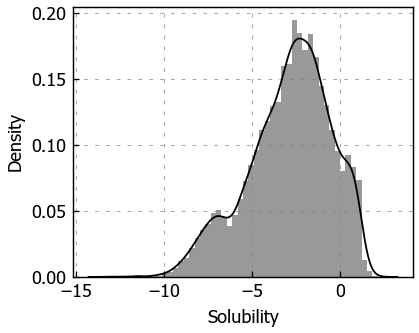

In [5]:
sns.distplot(soldata.Solubility)
plt.show()

Above we can see the histogram of the solubility with kernel density estimate overlaid. The histogram shows that the solubility varies from about -13 to 2.5 and is not normally distributed. 

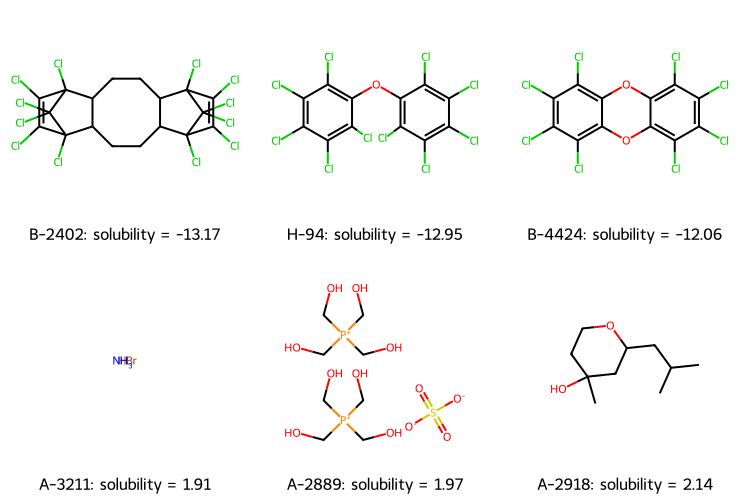

In [36]:
# get 3 lowest and 3 highest solubilities
soldata_sorted = soldata.sort_values("Solubility")
extremes = pd.concat([soldata_sorted[:3], soldata_sorted[-3:]])

# We need to have a list of strings for legends
legend_text = [ f"{x.ID}: solubility = {x.Solubility:.2f}" for x in extremes.itertuples() ]

# now plot them on a grid
extreme_mols = [rdkit.Chem.MolFromInchi(inchi) for inchi in extremes.InChI]
rdkit.Chem.Draw.MolsToGridImage( extreme_mols, molsPerRow=3, subImgSize=(250, 250), legends=legend_text )

The figure of extreme molecules shows highly-chlorinated compounds have the lowest solubility and ionic compounds have higher solubility. Is A-2918 an **outlier**, a mistake? Also, is NH$_3$ really comparable to these organic compounds? These are the kind of questions that you should consider *before* doing any modeling.

```{margin} Outliers

Outliers are extreme values that fall outside of your normal data distribution. They can be mistakes or be from a different distribution (e.g., metals instead of organic molecules). Outliers can have a strong effect on model training.

```

### Feature Correlation
Now let's examine the features and see how correlated they are with solubility. Note that there are a few columns unrelated to features or solubility: `SD` (standard deviation), `Ocurrences` (how often the molecule occurred in the constituent databases), and `Group` (where the data came from).

In [9]:
# soldata.columns.tolist()

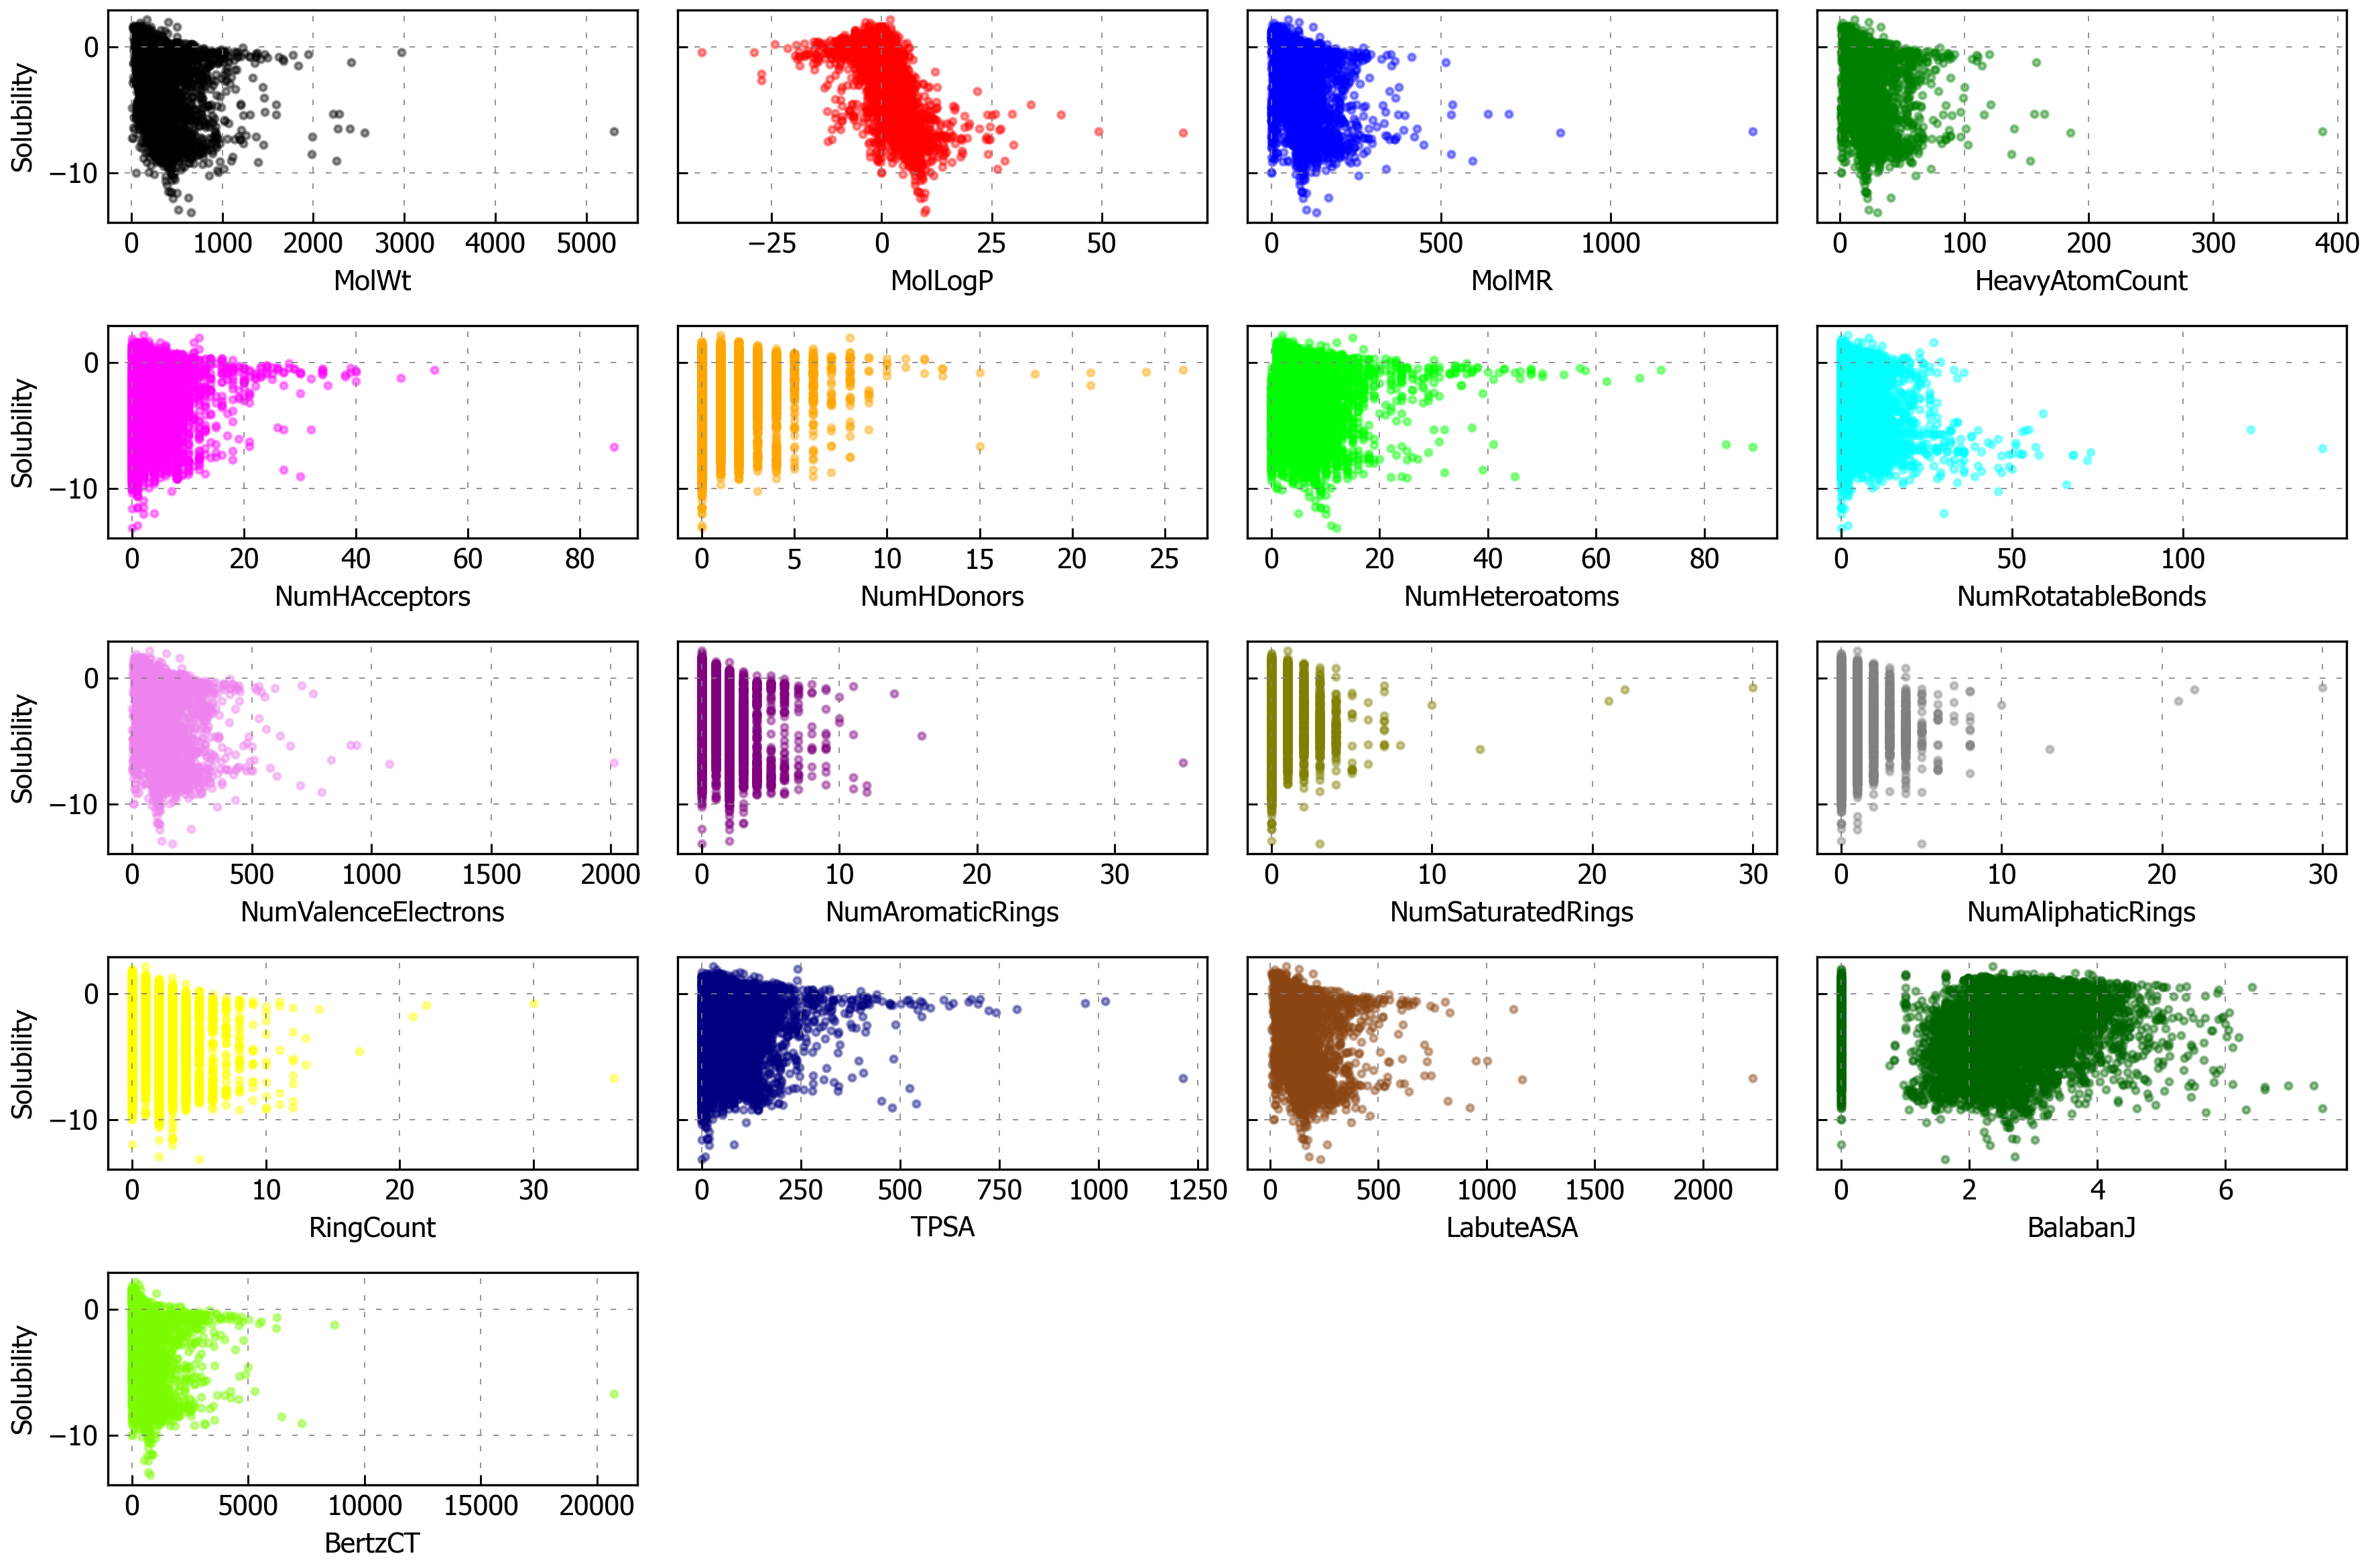

In [6]:
features_start_at = list(soldata.columns).index("MolWt")
feature_names = soldata.columns[features_start_at:]

fig, axs = plt.subplots(nrows=5, ncols=4, sharey=True, figsize=(12, 8), dpi=300)
axs = axs.flatten()  # so we don't have to slice by row and column
for i, n in enumerate(feature_names):
    ax = axs[i]
    ax.scatter( soldata[n], soldata.Solubility, s=6, alpha=0.4, color=f"C{i}"  )  # add some color
    if i % 4 == 0:
        ax.set_ylabel("Solubility")
    ax.set_xlabel(n)
# hide empty subplots
for i in range(len(feature_names), len(axs)):
    fig.delaxes(axs[i])
plt.tight_layout()
plt.show()

It's interesting that molecular weight or hydrogen bond numbers seem to have little correlation, at least from this plot. MolLogP, which is a calculated descriptor related to solubility, does correlate well. You can also see that some of these features have low **variance**, meaning the value of the feature changes little or not at all for many data points (e.g., "NumHDonors").

### Linear Model

Let's begin with one of the simplest approaches — a linear model. This is our first type of supervised learning and is rarely used due to something we'll see — the difficult choice of features. 


```{margin} Autodiff
[Autodiff](https://en.wikipedia.org/wiki/Automatic_differentiation) is a computer program tool
that can compute analytical gradients with respect to two variables in a program. 
```

Our model will be defined by this equation:

\begin{equation}
    y = \vec{w} \cdot \vec{x} + b
\end{equation}

which is defined for a single data point. The shape of a single feature vector,  $\vec{x}$, is 17 in our case (for the 17 features). $\vec{w}$ is a vector of adjustable parameters of length 17 and $b$ is an adjustable scalar (called **bias**).

We'll implement this model using a library called [``jax``](https://jax.readthedocs.io/en/latest/notebooks/quickstart.html) that is very similar to numpy except it can compute analytical gradients easily via autodiff.


In [38]:
def linear_model(x, w, b):
    return jnp.dot(x, w) + b


# test it out
x = np.array([1, 0, 2.5])
w = np.array([0.2, -0.5, 0.4])
b = 4.3

linear_model(x, w, b)

DeviceArray(5.5, dtype=float32)

```{margin} Loss
A loss is a function which takes in a model prediction $\hat{y}$,
labels $y$, and computes a scalar representing how poor the fit is.
Our goal is to minimize loss.
```

Now comes the critical question: *How do we find the adjustable parameters $\vec{w}$ and $b$*? The classic solution for linear regression is computing the adjustable parameters directly with a pseudo-inverse, $\vec{w} = (X^TX)^{-1}X^{T}\vec{y}$. You can read more about [this here](https://nbviewer.jupyter.org/github/whitead/numerical_stats/blob/master/unit_12/lectures/lecture_1.ipynb#Extending-Least-Squares-to-Multiple-Dimensions-in-Domain---OLS-ND). We'll use an **iterative** approach that mirrors what we'll do in deep learning. This is not the correct approach for linear regression, but it'll be useful for us to get used to the iterative approach since we'll see it so often in deep learning. 

To iteratively find our adjustable parameters, we will pick a **loss** function and minimize with **gradients**. Let's define these quantities and compute our loss with some initial random w and b.

In [39]:
# convert data into features, labels
features = soldata.loc[:, feature_names].values
labels = soldata.Solubility.values

feature_dim = features.shape[1]

# initialize our paramaters
w = np.random.normal(size=feature_dim)
b = 0.0

# define loss
def loss(y, labels):
    return jnp.mean((y - labels) ** 2)


# test it out
y = linear_model(features, w, b)
loss(y, labels)

DeviceArray(554111.4, dtype=float32)

Wow! Our loss is terrible, especially considering that solubilities are between -13 and 2. But, that's right since we just guessed our initial parameters. 



### Gradient Descent

We will now try to reduce loss by using information about how it changes with respect to the adjustable parameters. If we write our loss as:

\begin{equation}
    L = \frac{1}{N}\sum_i^N \left[y_i - f(\vec{x}_i, \vec{w}, b)\right]^2
\end{equation}

This loss is called **mean squared error**, often abbreviated MSE. We can compute our loss gradients with respect to the adjustable parameters:

```{margin} jax.grad
[jax.grad](https://jax.readthedocs.io/en/latest/jax.html#jax.grad) computes an analytical derivative of a Python function. 
It takes two arguments: the function and which args to 
take the derivative of. For example, consider `f(x, y, z)`, then `jax.grad(f,(1,2))`
gives $\frac{\partial f}{\partial x}, \frac{\partial f}{\partial y}$. Note too that
$x$ may be a tensor. 
```

\begin{equation}
    \frac{\partial L}{\partial w_i}, \frac{\partial L}{\partial b}
\end{equation}

where $w_i$ is the $i$th element of the weight vector $\vec{w}$. We can reduce the loss by taking a step in the direction of its negative gradient:
\begin{equation}
    (w_i, b') = \left(w_i - \eta \frac{\partial L}{\partial w_i}, b - \eta\frac{\partial L}{\partial b}\right)
\end{equation}

where $\eta$ is **learning rate**, which an adjustable but not trained parameter (an example of a **hyperparameter**) which we just guess to be $1\times10^{-6}$ in this example. Typically, it's chosen to be some power of 10 that is at most 0.1. Values higher than that cause stability problems. Let's try this procedure, which is called **gradient descent**.


In [40]:
# compute gradients
def loss_wrapper(w, b, data):
    features = data[0]
    labels = data[1]
    y = linear_model(features, w, b)
    return loss(y, labels)


loss_grad = jax.grad(loss_wrapper, (0, 1))

# test it out
loss_grad(w, b, (features, labels))

(DeviceArray([4.34213906e+05, 2.99283130e+03, 1.09366477e+05,
              2.90330176e+04, 6.03893506e+03, 1.46635278e+03,
              8.63276855e+03, 6.12605518e+03, 1.52025359e+05,
              2.27809106e+03, 3.70779419e+02, 6.98108032e+02,
              2.97619263e+03, 1.00468695e+05, 1.80537688e+05,
              1.86782349e+03, 1.06673350e+06], dtype=float32),
 DeviceArray(949.38837, dtype=float32, weak_type=True))

We've computed the gradient. Now we'll minimize it over a few steps.

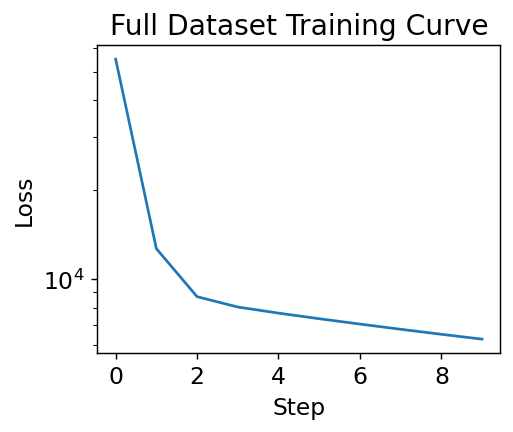

In [41]:
loss_progress = []
eta = 1e-6
data = (features, labels)
for i in range(10):
    grad = loss_grad(w, b, data)
    w -= eta * grad[0]
    b -= eta * grad[1]
    loss_progress.append(loss_wrapper(w, b, data))
plt.plot(loss_progress)

plt.xlabel("Step")
plt.yscale("log")
plt.ylabel("Loss")
plt.title("Full Dataset Training Curve")
plt.show()

### Training Curve

The figure above is called a **training curve**. We'll see these frequently in this book and they show us if the loss is decreasing, indicating the model is learning. Training curves are also called **learning curves**. The x-axis may be example number, total iterations through dataset (called **epochs**), or some other measure of amount of data used for training the model.

### Batching

```{margin} batch
A batch is a subset of your data of size *batch size*. Batch size is usually as a power of 2 (e.g., 16, 128).
Having random batches of data is how gradient descent becomes stochastic gradient descent.
```

This is making good progress. But let's try to speed things up with a small change. We'll use **batching**, which is how training is actually done in machine learning.  The small change is that rather than using all data at once, we only take a small **batch** of data. Batching provides two benefits: it reduces the amount of time to compute an update to our parameters, and it makes the training process random. The randomness makes it possible to escape local minima that might stop training progress. This addition of batching makes our algorithm **stochastic** and thus we call this procedure **stochastic gradient descent** (SGD). SGD, and variations of it, are the most common methods of training in deep learning.


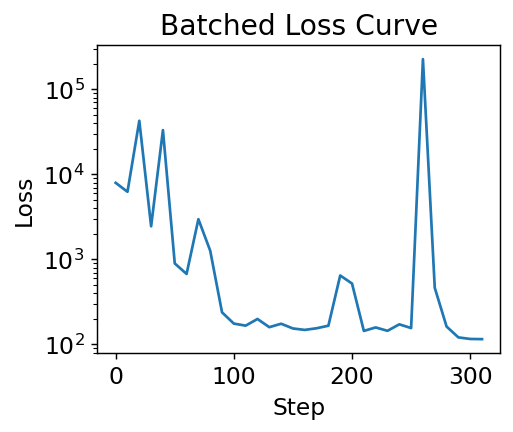

In [42]:
# initialize our paramaters
# to be fair to previous method
w = np.random.normal(size=feature_dim)
b = 0.0

loss_progress = []
eta = 1e-6
batch_size = 32
N = len(labels)  # number of data points
data = (features, labels)
# compute how much data fits nicely into a batch and drop extra data
new_N = len(labels) // batch_size * batch_size

# the -1 means that numpy will compute
# what that dimension should be
batched_features = features[:new_N].reshape((-1, batch_size, feature_dim))
batched_labels = labels[:new_N].reshape((-1, batch_size))
# to make it random, we'll iterate over the batches randomly
indices = np.arange(new_N // batch_size)
np.random.shuffle(indices)
for i in indices:
    # choose a random set of
    # indices to slice our data
    grad = loss_grad(w, b, (batched_features[i], batched_labels[i]))
    w -= eta * grad[0]
    b -= eta * grad[1]
    # we still compute loss on whole dataset, but not every step
    if i % 10 == 0:
        loss_progress.append(loss_wrapper(w, b, data))

plt.plot(np.arange(len(loss_progress)) * 10, loss_progress)
plt.xlabel("Step")
plt.yscale("log")
plt.ylabel("Loss")
plt.title("Batched Loss Curve")
plt.show()

There are three changes to note:

1. The loss is lower than without batching
2. There are more steps, even though we iterated over our dataset once instead of 10 times
3. The loss doesn't always go down

The reason the loss is lower is because we're able to take more steps even though we only see each data point once. That's because we update at each batch, giving more updates per iteration over the dataset. Specifically if $B$ is batch size, there are $N / B$ updates for every 1 update in the original gradient descent. The reason the loss doesn't always go down is that each time we evaluate it, it's on a different set of data. Some molecules are harder to predict than others. Also, each step we take in minimizing loss may not be correct because we only updated our parameters based on one batch. Assuming our batches are mixed though, we will always improve in expectation (on average). 

### Standardize features

It seems we cannot get past a certain loss. If you examine the gradients you'll see some of them are very large and some are very small. Each of the features have different magnitudes. For example, molecular weights are large numbers. The number of rings in a molecule is a small number. Each of these must use the same learning rate, $\eta$, and that is ok for some but too small for others. If we increase $\eta$, our training procedure will explode because of these larger feature gradients. A standard trick we can do is make all the features have the same magnitude, using the equation for standardization you might see in your statistics textbook:

\begin{equation}
    x_{ij} = \frac{x_{ij} - \bar{x_j}}{\sigma_{x_j}}
\end{equation}

where $\bar{x_j}$ is column mean and $\sigma_{x_j}$ is column standard deviation. To be careful about contaminating **training data** with **test data** -- leaking information between train and test data -- we should only use training data in computing the mean and standard deviation. We want our test data to approximate how we'll use our model on unseen data, so we cannot know what these unseen features means/standard deviations might be and thus cannot use them at training time for standardization. 

In [43]:
fstd = np.std(features, axis=0)
fmean = np.mean(features, axis=0)
std_features = (features - fmean) / fstd

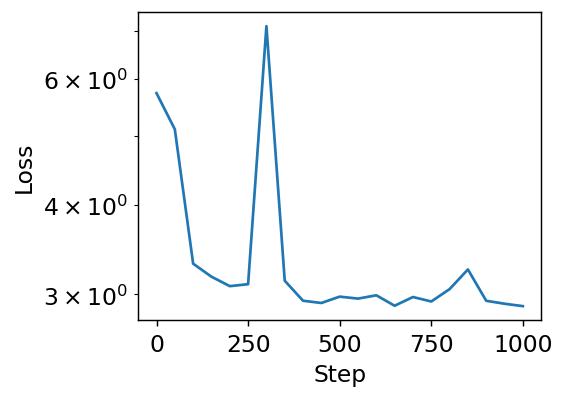

In [44]:
# initialize our paramaters
# since we're changing the features
w = np.random.normal(scale=0.1, size=feature_dim)
b = 0.0


loss_progress = []
eta = 1e-2
batch_size = 32
N = len(labels)  # number of data points
data = (std_features, labels)
# compute how much data fits nicely into a batch
# and drop extra data
new_N = len(labels) // batch_size * batch_size
num_epochs = 3

# the -1 means that numpy will compute
# what that dimension should be
batched_features = std_features[:new_N].reshape((-1, batch_size, feature_dim))
batched_labels = labels[:new_N].reshape((-1, batch_size))
indices = np.arange(new_N // batch_size)

# iterate through the dataset 3 times
for epoch in range(num_epochs):
    # to make it random, we'll iterate over the batches randomly
    np.random.shuffle(indices)
    for i in indices:
        # choose a random set of
        # indices to slice our data
        grad = loss_grad(w, b, (batched_features[i], batched_labels[i]))
        w -= eta * grad[0]
        b -= eta * grad[1]
        # we still compute loss on whole dataset, but not every step
        if i % 50 == 0:
            loss_progress.append(loss_wrapper(w, b, data))

plt.plot(np.arange(len(loss_progress)) * 50, loss_progress)
plt.xlabel("Step")
plt.yscale("log")
plt.ylabel("Loss")
plt.show()

Notice we safely increased our learning rate to 0.01, which is possible because all the features are of similar magnitude. We also could keep training, since we're gaining improvements. 

### Analyzing Model Performance

This is a large topic that we'll explore more, but the first thing we typically examine in supervised learning is a **parity plot**, which shows our predictions vs. our label prediction. What's nice about this plot is that it works no matter what the dimensions of the features are. A perfect fit would fall onto the line at $y = \hat{y}$

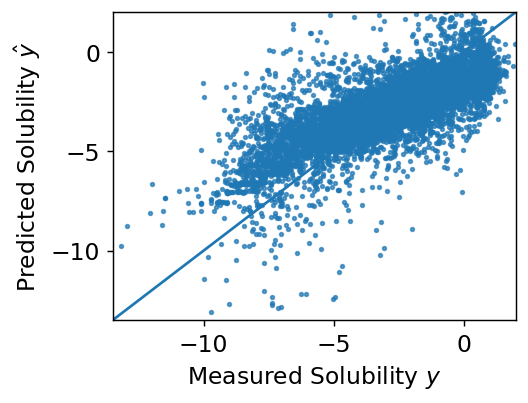

In [45]:
predicted_labels = linear_model(std_features, w, b)

plt.plot([-100, 100], [-100, 100])
plt.scatter(labels, predicted_labels, s=4, alpha=0.7)
plt.xlabel("Measured Solubility $y$")
plt.ylabel("Predicted Solubility $\hat{y}$")
plt.xlim(-13.5, 2)
plt.ylim(-13.5, 2)
plt.show()

Final model assessment can be done with loss, but typically other metrics are also used. In regression, a **correlation coefficient** is typically reported in addition to loss. In our example, this is computed as

In [46]:
# slice correlation between predict/labels from correlation matrix
np.corrcoef(labels, predicted_labels)[0, 1]

0.7004027073276268

A correlation coefficient of {glue:}`corr` is OK, but not great.

## Unsupervised Learning

In unsupervised learning, the goal is to predict $\hat{y}$ *without* labels. This seems like an impossible task. How do we judge success? Typically, unsupervised learning can be broken into three categories:

**Clustering**

&nbsp;&nbsp;&nbsp;&nbsp; Here we assume $\{y_i\}$ is a class variable and try to partition our features into these classes. In clustering we are simultaneously learning the definition of the classes (called clusters) and which cluster each feature should be assigned to.

```{margin} Class
In machine learning, a class is a type of label like ``dog`` or ``cat``. Formally,
we have a set of possible labels (e.g., all animals) and each feature vector has one (hard) or a 
probability distribution of classes (soft).
```

**Finding Signal**

&nbsp;&nbsp;&nbsp;&nbsp; $x$ is assumed to be made of two components: noise and signal ($y$). We try to separate the signal $y$ from $x$ and discard noise. Highly-related with **representation learning**, which we'll see later.


**Generative**

&nbsp;&nbsp;&nbsp;&nbsp; Generative methods are methods where we try to learn $P(\vec{x})$ so that we can sample new values of $\vec{x}$. It is analogous to $y$ being probability and we're trying to estimate it. We'll see these more later.



### Clustering

Clustering is historically one of the most well-known and still popular machine learning methods. It's always popular because it can provide new insight from data. Clustering gives class labels where none existed and thus can help find patterns in data. This is also a reason that it has become less popular in chemistry (and most fields): there is no right or wrong answer. Two people doing clustering independently will often arrive at different answers. Nevertheless, it should be a tool you know and can be a good exploration strategy.

```{margin} cluster labels
Clustering comes in many variants and some blur what exactly $y_i$ is. For example, in some clustering methods $y_i$ can include no assignment or $y_i$ is not a single class, but a tree of classes.
```

We'll look at the classic clustering method: k-means. Wikipedia has a [great article](https://en.wikipedia.org/wiki/K-means_clustering) on this classic algorithm, so I won't try to repeat that. To make our clustering actually visible, we'll start by projecting our features into 2 dimensions. This will be covered in representation learning, so don't worry about these steps.

In [47]:
# get down to 2 dimensions for easy visuals
embedding = sklearn.manifold.Isomap(n_components=2)
# only fit to every 25th point to make it fast
embedding.fit(std_features[::25, :])
reduced_features = embedding.transform(std_features)

We're going to zoom into the middle 99th percentile of the data since some of the points are extremely far away (though that is interesting!). 

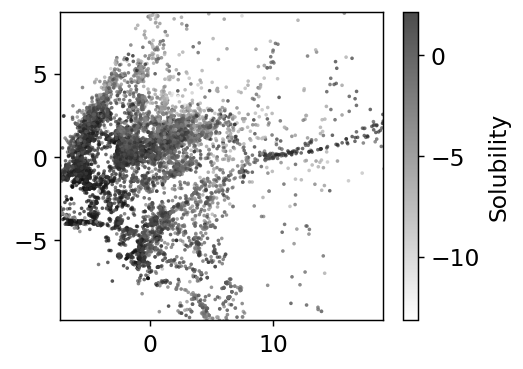

In [48]:
xlow, xhi = np.quantile(reduced_features, [0.005, 0.995], axis=0)

plt.scatter(
    reduced_features[:, 0],
    reduced_features[:, 1],
    s=4,
    alpha=0.7,
    c=labels,
    edgecolors="none",
)
plt.xlim(xlow[0], xhi[0])
plt.ylim(xlow[1], xhi[1])
cb = plt.colorbar()
cb.set_label("Solubility")
plt.show()

```{margin} Dimensionality Reduction
Reducing $\vec{x}$, your feature vectors to a low
dimensional space. The classic example is PCA, which is a 
linear operator. However, most prefer nonlinear methods 
like [t-SNE](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html).
```



The dimensionality reduction has made our features only 2 dimensions. We can see some structure, especially with the solubility as the coloring. Note in these kind of plots, where we have reduced dimensions in someway, we do not label the axes because they are arbitrary.

Now we cluster. The main challenge in clustering is deciding how many clusters there should be. There are a number of methods out there, but they basically come down to intuition. You, as the chemist, should use some knowledge outside of the data to intuit what is the cluster number. Sounds unscientific? Yeah, that's why clustering is hard.

In [49]:
# cluster - using whole features
kmeans = sklearn.cluster.KMeans(n_clusters=4, random_state=0)
kmeans.fit(std_features)

KMeans(n_clusters=4, random_state=0)

Very simple procedure! Now we'll visualize by coloring our data by the class assigned. 

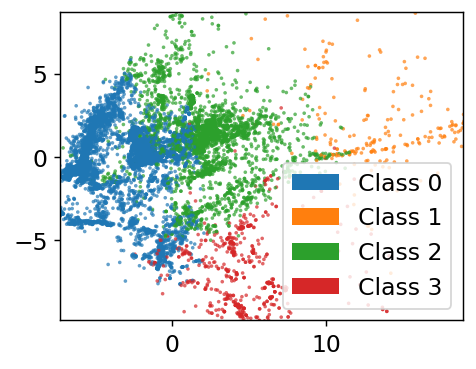

In [50]:
point_colors = [f"C{i}" for i in kmeans.labels_]
plt.scatter(
    reduced_features[:, 0],
    reduced_features[:, 1],
    s=4,
    alpha=0.7,
    c=point_colors,
    edgecolors="none",
)
# make legend
legend_elements = [
    plt.matplotlib.patches.Patch(
        facecolor=f"C{i}", edgecolor="none", label=f"Class {i}"
    )
    for i in range(4)
]
plt.legend(handles=legend_elements)
plt.xlim(xlow[0], xhi[0])
plt.ylim(xlow[1], xhi[1])
plt.show()

### Choosing Cluster Number

How do we know we had the correct number? Intuition. There is one tool we can use to help us, called an **elbow plot**. The k-means clusters can be used to compute the mean squared distance from cluster center, basically a version of loss function. However, if we treat cluster number as a trainable parameter we'd find the best fit at the cluster number being equal to number of data points. Not helpful! However, we can see when the slope of this loss becomes approximately constant and assume that those extra clusters are adding no new insight. Let's plot the loss and see what happens. Note we'll be using a subsample of the dataset to save time.

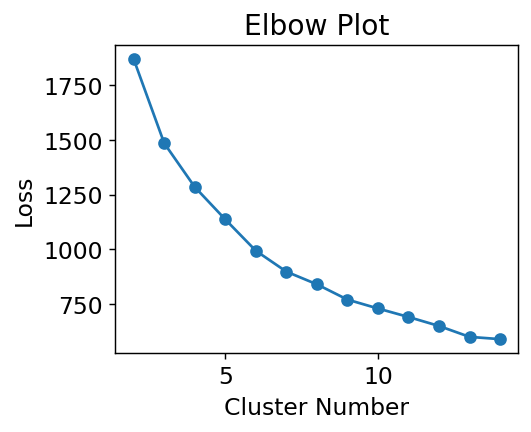

In [51]:
# make an elbow plot
loss = []
cn = range(2, 15)
for i in cn:
    kmeans = sklearn.cluster.KMeans(n_clusters=i, random_state=0)
    # use every 50th point
    kmeans.fit(std_features[::50])
    # we get score -> opposite of loss
    # so take -
    loss.append(-kmeans.score(std_features[::50]))

plt.plot(cn, loss, "o-")
plt.xlabel("Cluster Number")
plt.ylabel("Loss")
plt.title("Elbow Plot")
plt.show()

Where is the transition? If I squint, maybe at 6? 3? 4? 7? Let's choose 4 because it sounds nice and is plausible based on the data. The last task is to get some insight into what the clusters actually are. We can extract the most centered data points (closest to cluster center) and consider them to be representative of the cluster. 

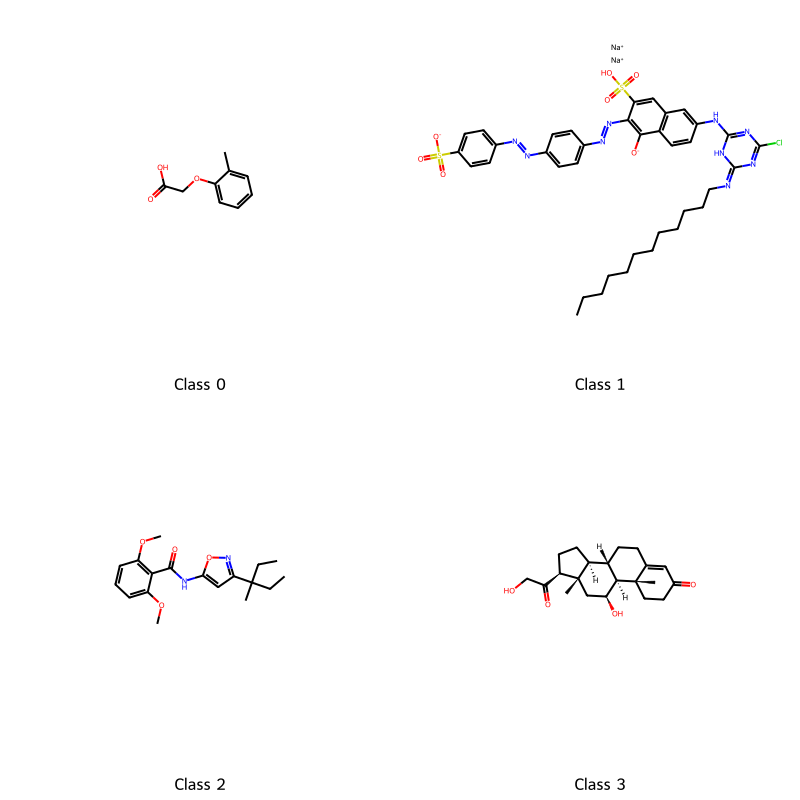

In [52]:
# cluster - using whole features
kmeans = sklearn.cluster.KMeans(n_clusters=4, random_state=0)
kmeans.fit(std_features)

cluster_center_idx = []
for c in kmeans.cluster_centers_:
    # find point closest
    i = np.argmin(np.sum((std_features - c) ** 2, axis=1))
    cluster_center_idx.append(i)
cluster_centers = soldata.iloc[cluster_center_idx, :]

legend_text = [f"Class {i}" for i in range(4)]

# now plot them on a grid
cluster_mols = [rdkit.Chem.MolFromInchi(inchi) for inchi in cluster_centers.InChI]
rdkit.Chem.Draw.MolsToGridImage(
    cluster_mols, molsPerRow=2, subImgSize=(400, 400), legends=legend_text
)

So what exactly are these classes? Unclear. We intentionally did not reveal solubility (unsupervised learning) so there is not necessarily any connection with solubility. These classes are more a result of which features were chosen for the dataset. You could make a hypothesis, like class 1 is all negatively charged or class 0 is aliphatic, and investigate. Ultimately though there is no *best* clustering and often unsupervised learning is more about finding insight or patterns and not about producing a highly-accurate model.

The elbow plot method is one of many approaches to selecting cluster number {cite}`pham2005selection`. I prefer it because it's quite clear that you are using intuition. More sophisticated methods sort-of conceal the fact that there is no right or wrong answer in clustering. 



```{note}
This process does not result in a function that predicts solubility. We might try to gain insight about predicting solubility with our predicted classes, but that is not the goal of clustering.
```

## Chapter Summary

* Supervised machine learning is building models that can predict labels $y$ from input features $\vec{x}$.
* Data can be labeled or unlabeled. 
* Models are trained by minimizing loss with stochastic gradient descent.
* Unsupervised learning is building models that can find patterns in data.
* Clustering is unsupervised learning where the model groups the data points into clusters

## Cited References

```{bibliography}
:style: unsrtalpha
:filter: docname in docnames
```